# GAN trainning process

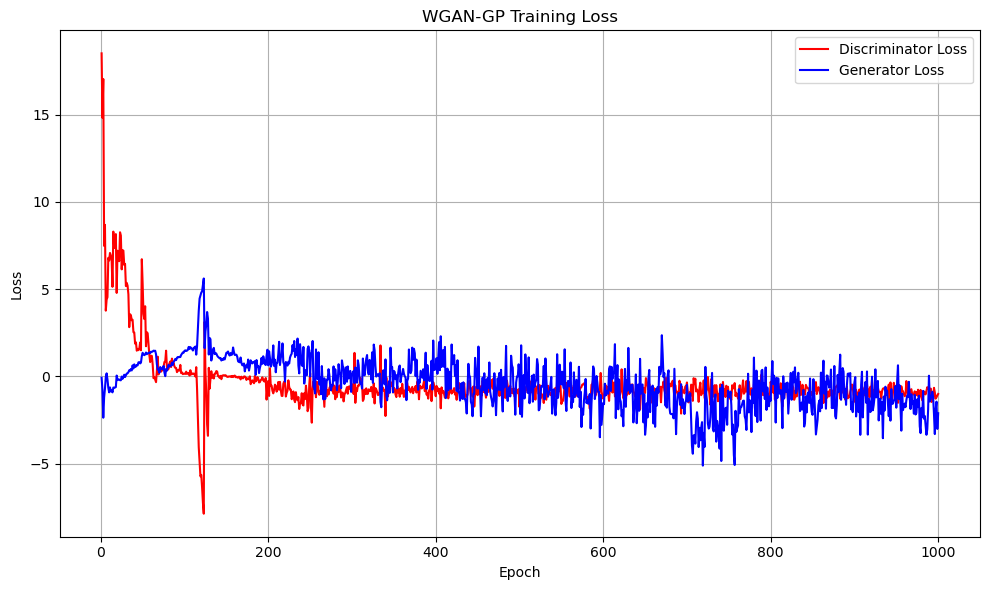

In [1]:
from utils.visualize import visualize_gan_losses

visualize_gan_losses("./logs/aug_GAN/20250617_214011/train.log")